In [1]:
pip install llmsherpa neo4j openai --upgrade typing_extensions cohere tiktoken llama-index pandas langchain fpdf

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# ***I. KG Building ***

Knowledge graphs are emerging as a pivotal technique for organizing and distilling the exponential growth of information. However, manual construction of enterprise-scale knowledge graphs is infeasible. Recent advances in large language models (LLMs) open new possibilities for automating parts of this process.

We can categorize two primary approaches for leveraging LLMs to accelerate knowledge graph creation:

# I/ Documents as a Knowledge Graph
Apply LLMs to extract key entities and relationships within a corpus of documents
Link concepts across documents to enable a "semantic search"
Power document retrieval and question answering through a knowledge graph representation of the contents

# II/ Domain Information Extraction in order to create Property Graphs
Fine-tune LLMs to identify key entities and relations from any input text
Output canonical knowledge graph triplets representing an ontology
Enables reasoning and inference over conceptual knowledge
The first methodology is simpler and more achievable today by exploiting LLMs' innate capabilities. We will demonstrate constructing a Document Knowledge Graph across research papers and using it to fuel a semantic search system.

The second approach requires additional tuning for LLMs to reach sufficient accuracy. We will provide an overview and outlook for this Domain Information Extraction methodology, as fully automating complex ontology development remains an open challenge.

With these complementary techniques, LLMs are positioned to transform knowledge graph construction by alleviating bottlenecks around manual labeling and information integration. This unlocks new frontiers in analytics, search, and knowledge-enabled AI across verticals.


The integration of Knowledge Graphs (KGs) and ontology into production-grade Retriever-Augmented Generation (RAG) systems undoubtedly offers enhanced accuracy compared to mere vector searches of data chunks. This superiority stems from the structured and semantically rich nature of knowledge graphs, allowing for more precise information retrieval and contextual understanding.

However, this approach is not without its challenges, particularly in terms of latency. Constructing and querying these knowledge graphs, especially for large datasets, can be computationally demanding. This challenge is twofold: firstly, the initial creation of the graph requires substantial computation, and secondly, real-time querying within these graphs can introduce latency.

To mitigate these issues, ongoing research and development in more efficient graph construction algorithms are crucial. These advancements aim to streamline the graph creation process, making it less resource-intensive. Additionally, exploring the use of local graphs—smaller, more focused knowledge structures—can offer a balance between the depth of knowledge and computational efficiency. Local graphs can provide relevant and detailed information without the overhead of querying vast, comprehensive datasets.

While the incorporation of KGs and ontology into RAG systems promises improved accuracy, it is important to navigate the computational challenges, particularly latency, through innovative solutions and optimizations in graph construction and querying methodologies.

RDF (Resource Description Framework) graphs and property graphs are both used to model connected data, but they differ in structure, semantics, and use cases.

RDF graphs represent data as subject-predicate-object triples, with the focus on knowledge representation using formal semantics and ontologies. RDF graphs often rely on triple stores and have a more rigid schema. They enable better data governance and flexibility, but can be complex for deep searches⁠

On the other hand, property graphs use nodes (vertices) and relationships (edges) to represent data, with both nodes and relationships having properties (key-value pairs). They are more flexible, allowing traversal across relationships to find connections and patterns. Property graphs are optimized for connected data storage and querying, and naturally leverage graph databases optimized for storing and querying connected data at scale⁠

An ontology in the context of computer science and information science is a representation, formal naming, and definition of the categories, properties, and relations between the concepts, data, and entities that substantiate one, many, or all domains of discourse. It provides a shared vocabulary used to model a domain — that is, the type of objects and concepts that exist, and their properties and relations.

RDF (Resource Description Framework) graphs allow the representation of ontology as they are built on a formal model with explicit semantics. They use subject-predicate-object triples to structure data. This structure, along with the use of URIs for resources/entities and predicates, allows the RDF graphs to define and link data in a way that represents the ontology of a domain.

On the other hand, property graphs are designed for storing connected data. They use nodes and relationships (where both can have properties in the form of key-value pairs) to represent data. This allows property graphs to store knowledge by capturing details about entities and their interconnections. However, unlike RDF graphs, they don't have a built-in formal model for representing ontology. Instead, they provide a flexible structure for storing and querying connected data, which can be beneficial in operational or transactional systems.

Both RDF graphs and property graphs can significantly enhance a Retrieval-Augmented Generation (RAG) system.

RDF graphs allow the representation of formal definitions and relationships modeled in the ontology. They can be used to align the vocabulary between the user's input and the knowledge graph, thereby facilitating accurate retrieval. They also enable reasoning over ontology relationships to expand the search context.

Property graphs, on the other hand, provide a flexible structure for storing and querying connected data. They allow the construction of relationships between key concepts, leading to more precise and referenced responses. Property graphs also offer an additional layer of interpretability and relatedness that can improve the performance of RAG systems

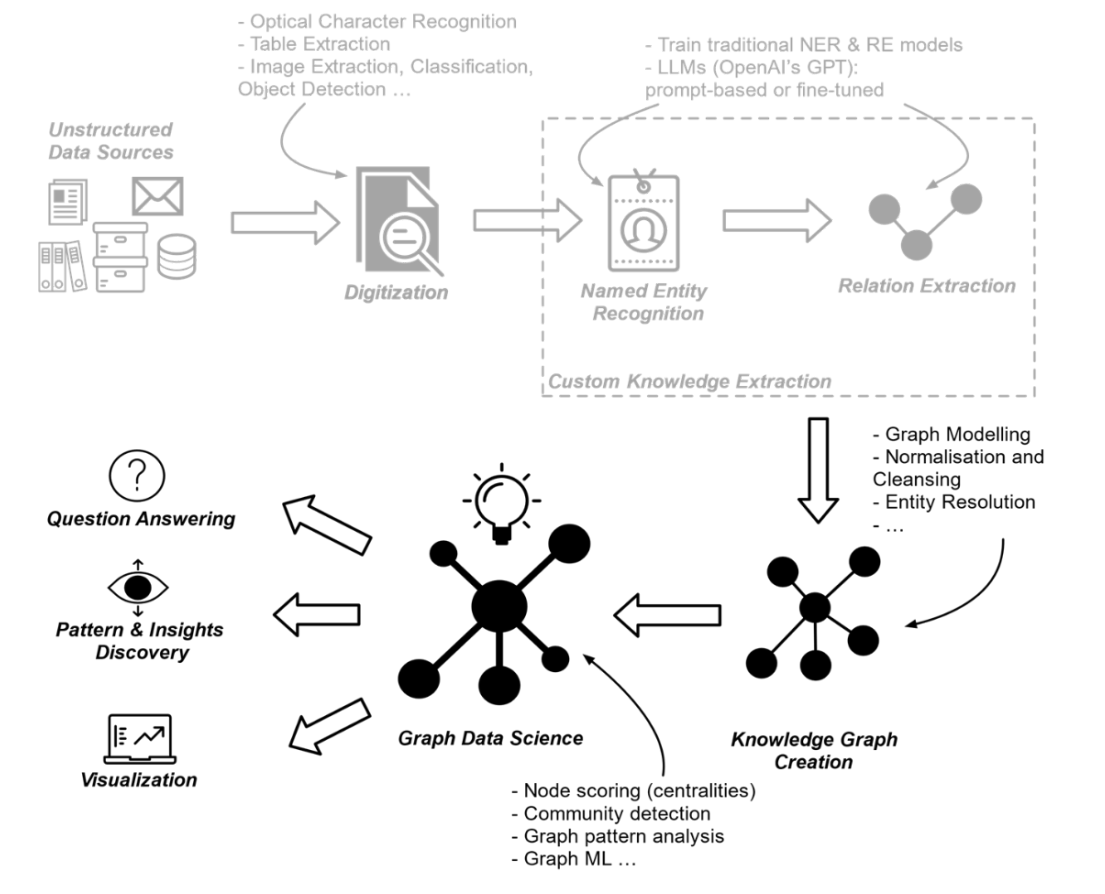

# I/ *Documents* as a Knowledge Graph (Building a property graph out of a document)

Building a property graph out of a document, essentially treating documents as a knowledge graph, has several benefits:

1. It provides a flexible schema that can accommodate evolving document structures.
2. It enables efficient relationship queries using graph traversal, allowing for a deeper understanding of the connections within the data.
3. It enhances data linking with multiple relationships, providing a more comprehensive view of linked information.
4. It offers intuitive visualization for exploring connections, which can aid in data analysis.
5. It scales well for large, interconnected datasets.

Essentially, this approach allows complex document relationships to be leveraged for better understanding and navigation of the information contained within the documents.

In [2]:
#
# This code will be 
#   - using LayoutPDFReader to read PDF files
#   - mapping PDF elements into a property graph
#   - saving PDF elements into Neo4j
#

from llmsherpa.readers import LayoutPDFReader

llmsherpa_api_url = "https://readers.llmsherpa.com/api/document/developer/parseDocument?renderFormat=all"

import os

# Replace 'your-api-key' with your actual OpenAI API key
os.environ["OPENAI_API_KEY"] = ""

In [ ]:
# Defines connection details and authentication for connecting to a Neo4j database (NEO4J_URL, NEO4J_USER, NEO4J_PASSWORD, NEO4J_DATABASE).
# Defines a list of Cypher queries that will be used to create nodes and relationships in the graph (cypher_pool). These include queries to:
# Create Document, Section, Chunk and Table nodes
# Create relationships between them like HAS_DOCUMENT, UNDER_SECTION, HAS_PARENT
# Create unique constraints on the nodes
# For each document passed in:
# Creates a Document node
# Loops through sections in the doc to create Section nodes and connect to Document
# Loops through chunks in the doc to create Chunk nodes and connect to parent Section
# Loops through tables in the doc to create Table nodes and connect to parent Section or Document
# Uses hashlib to create hash IDs for nodes based on content to ensure uniqueness
# Prints out a summary of nodes created for each document

"""
In the provided code, various properties are created and associated with different types of nodes in a Neo4j graph database. These nodes represent documents, sections, chunks, and tables extracted from a document. The properties are as follows:

Document Node Properties:

url_hash: A unique hash value computed from the document's URL, used as an identifier.
url: The URL of the document.
Section Node Properties:

key: A unique identifier for the section, constructed from the document URL hash, block index, and title hash.
page_idx: Page index of the section within the document.
title_hash: A hash value computed from the section title.
block_idx: The index of the block within the document where the section starts.
title: The title of the section.
tag: A tag for the section (e.g., type or category).
level: The level of the section, indicating its depth in the document structure.
Chunk Node Properties:

key: A unique identifier for the chunk, constructed from the document URL hash, block index, and sentences hash.
sentences: The text content of the chunk.
sentences_hash: A hash value computed from the chunk's sentences.
block_idx: The block index of the chunk within the document.
page_idx: The page index of the chunk within the document.
tag: A tag for the chunk (e.g., type or category).
level: The level of the chunk in the document structure.
Table Node Properties:

key: A unique identifier for the table, constructed from the document URL hash, block index, and table name.
name: The name of the table.
doc_url_hash: The hash of the document URL where the table is found.
block_idx: The block index of the table within the document.
page_idx: The page index of the table within the document.
html: The HTML representation of the table.
rows: The number of rows in the table.
Additionally, the script includes Cypher queries for creating relationships between these nodes, such as HAS_DOCUMENT, UNDER_SECTION, and HAS_PARENT, as well as unique constraints to ensure the uniqueness of certain properties. 
The script also initializes a vector index for the Embedding nodes. This structure is designed to facilitate the organization, retrieval, and analysis of complex document structures within a Neo4j graph database.
"""

# Please change the following variables to your own Neo4j instance
NEO4J_URL = "neo4j+s://e06cd449.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "odDj37W_tSphbXefQ4HlBKsltwidiQDkwF6wlxYwzwY"
NEO4J_DATABASE = "neo4j"


def initialiseNeo4j():
    cypher_schema = [
        "CREATE CONSTRAINT sectionKey IF NOT EXISTS FOR (c:Section) REQUIRE (c.key) IS UNIQUE;",
        "CREATE CONSTRAINT chunkKey IF NOT EXISTS FOR (c:Chunk) REQUIRE (c.key) IS UNIQUE;",
        "CREATE CONSTRAINT documentKey IF NOT EXISTS FOR (c:Document) REQUIRE (c.url_hash) IS UNIQUE;",
        "CREATE CONSTRAINT tableKey IF NOT EXISTS FOR (c:Table) REQUIRE (c.key) IS UNIQUE;",
        "CALL db.index.vector.createNodeIndex('chunkVectorIndex', 'Embedding', 'value', 1536, 'COSINE');"
    ]

    driver = GraphDatabase.driver(NEO4J_URL, database=NEO4J_DATABASE, auth=(NEO4J_USER, NEO4J_PASSWORD))

    with driver.session() as session:
        for cypher in cypher_schema:
            session.run(cypher)
    driver.close()


def ingestDocumentNeo4j(doc, doc_location):


    cypher_pool = [
        # 0 - Document
        "MERGE (d:Document {url_hash: $doc_url_hash_val}) ON CREATE SET d.url = $doc_url_val RETURN d;",
        # 1 - Section
        "MERGE (p:Section {key: $doc_url_hash_val+'|'+$block_idx_val+'|'+$title_hash_val}) ON CREATE SET p.page_idx = $page_idx_val, p.title_hash = $title_hash_val, p.block_idx = $block_idx_val, p.title = $title_val, p.tag = $tag_val, p.level = $level_val RETURN p;",
        # 2 - Link Section with the Document
        "MATCH (d:Document {url_hash: $doc_url_hash_val}) MATCH (s:Section {key: $doc_url_hash_val+'|'+$block_idx_val+'|'+$title_hash_val}) MERGE (d)<-[:HAS_DOCUMENT]-(s);",
        # 3 - Link Section with a parent section
        "MATCH (s1:Section {key: $doc_url_hash_val+'|'+$parent_block_idx_val+'|'+$parent_title_hash_val}) MATCH (s2:Section {key: $doc_url_hash_val+'|'+$block_idx_val+'|'+$title_hash_val}) MERGE (s1)<-[:UNDER_SECTION]-(s2);",
        # 4 - Chunk
        "MERGE (c:Chunk {key: $doc_url_hash_val+'|'+$block_idx_val+'|'+$sentences_hash_val}) ON CREATE SET c.sentences = $sentences_val, c.sentences_hash = $sentences_hash_val, c.block_idx = $block_idx_val, c.page_idx = $page_idx_val, c.tag = $tag_val, c.level = $level_val RETURN c;",
        # 5 - Link Chunk to Section
        "MATCH (c:Chunk {key: $doc_url_hash_val+'|'+$block_idx_val+'|'+$sentences_hash_val}) MATCH (s:Section {key:$doc_url_hash_val+'|'+$parent_block_idx_val+'|'+$parent_hash_val}) MERGE (s)<-[:HAS_PARENT]-(c);",
        # 6 - Table
        "MERGE (t:Table {key: $doc_url_hash_val+'|'+$block_idx_val+'|'+$name_val}) ON CREATE SET t.name = $name_val, t.doc_url_hash = $doc_url_hash_val, t.block_idx = $block_idx_val, t.page_idx = $page_idx_val, t.html = $html_val, t.rows = $rows_val RETURN t;",
        # 7 - Link Table to Section
        "MATCH (t:Table {key: $doc_url_hash_val+'|'+$block_idx_val+'|'+$name_val}) MATCH (s:Section {key: $doc_url_hash_val+'|'+$parent_block_idx_val+'|'+$parent_hash_val}) MERGE (s)<-[:HAS_PARENT]-(t);",
        # 8 - Link Table to Document if no parent section
        "MATCH (t:Table {key: $doc_url_hash_val+'|'+$block_idx_val+'|'+$name_val}) MATCH (s:Document {url_hash: $doc_url_hash_val}) MERGE (s)<-[:HAS_PARENT]-(t);"
    ]

    driver = GraphDatabase.driver(NEO4J_URL, database=NEO4J_DATABASE, auth=(NEO4J_USER, NEO4J_PASSWORD))

    with driver.session() as session:
        cypher = ""

        # 1 - Create Document node
        doc_url_val = doc_location
        doc_url_hash_val = hashlib.md5(doc_url_val.encode("utf-8")).hexdigest()

        cypher = cypher_pool[0]
        session.run(cypher, doc_url_hash_val=doc_url_hash_val, doc_url_val=doc_url_val)

        # 2 - Create Section nodes

        countSection = 0
        for sec in doc.sections():
            sec_title_val = sec.title
            sec_title_hash_val = hashlib.md5(sec_title_val.encode("utf-8")).hexdigest()
            sec_tag_val = sec.tag
            sec_level_val = sec.level
            sec_page_idx_val = sec.page_idx
            sec_block_idx_val = sec.block_idx

            # MERGE section node
            if not sec_tag_val == 'table':
                cypher = cypher_pool[1]
                session.run(cypher, page_idx_val=sec_page_idx_val
                                , title_hash_val=sec_title_hash_val
                                , title_val=sec_title_val
                                , tag_val=sec_tag_val
                                , level_val=sec_level_val
                                , block_idx_val=sec_block_idx_val
                                , doc_url_hash_val=doc_url_hash_val
                            )

                # Link Section with a parent section or Document

                sec_parent_val = str(sec.parent.to_text())

                if sec_parent_val == "None":    # use Document as parent

                    cypher = cypher_pool[2]
                    session.run(cypher, page_idx_val=sec_page_idx_val
                                    , title_hash_val=sec_title_hash_val
                                    , doc_url_hash_val=doc_url_hash_val
                                    , block_idx_val=sec_block_idx_val
                                )

                else:   # use parent section
                    sec_parent_title_hash_val = hashlib.md5(sec_parent_val.encode("utf-8")).hexdigest()
                    sec_parent_page_idx_val = sec.parent.page_idx
                    sec_parent_block_idx_val = sec.parent.block_idx

                    cypher = cypher_pool[3]
                    session.run(cypher, page_idx_val=sec_page_idx_val
                                    , title_hash_val=sec_title_hash_val
                                    , block_idx_val=sec_block_idx_val
                                    , parent_page_idx_val=sec_parent_page_idx_val
                                    , parent_title_hash_val=sec_parent_title_hash_val
                                    , parent_block_idx_val=sec_parent_block_idx_val
                                    , doc_url_hash_val=doc_url_hash_val
                                )
            # **** if sec_parent_val == "None":

            countSection += 1
        # **** for sec in doc.sections():


        # ------- Continue within the blocks -------
        # 3 - Create Chunk nodes from chunks

        countChunk = 0
        for chk in doc.chunks():

            chunk_block_idx_val = chk.block_idx
            chunk_page_idx_val = chk.page_idx
            chunk_tag_val = chk.tag
            chunk_level_val = chk.level
            chunk_sentences = "\n".join(chk.sentences)

            # MERGE Chunk node
            if not chunk_tag_val == 'table':
                chunk_sentences_hash_val = hashlib.md5(chunk_sentences.encode("utf-8")).hexdigest()

                # MERGE chunk node
                cypher = cypher_pool[4]
                session.run(cypher, sentences_hash_val=chunk_sentences_hash_val
                                , sentences_val=chunk_sentences
                                , block_idx_val=chunk_block_idx_val
                                , page_idx_val=chunk_page_idx_val
                                , tag_val=chunk_tag_val
                                , level_val=chunk_level_val
                                , doc_url_hash_val=doc_url_hash_val
                            )

                # Link chunk with a section
                # Chunk always has a parent section

                chk_parent_val = str(chk.parent.to_text())

                if not chk_parent_val == "None":
                    chk_parent_hash_val = hashlib.md5(chk_parent_val.encode("utf-8")).hexdigest()
                    chk_parent_page_idx_val = chk.parent.page_idx
                    chk_parent_block_idx_val = chk.parent.block_idx

                    cypher = cypher_pool[5]
                    session.run(cypher, sentences_hash_val=chunk_sentences_hash_val
                                    , block_idx_val=chunk_block_idx_val
                                    , parent_hash_val=chk_parent_hash_val
                                    , parent_block_idx_val=chk_parent_block_idx_val
                                    , doc_url_hash_val=doc_url_hash_val
                                )

                # Link sentence
                #   >> TO DO for smaller token length

                countChunk += 1
        # **** for chk in doc.chunks():

        # 4 - Create Table nodes

        countTable = 0
        for tb in doc.tables():
            page_idx_val = tb.page_idx
            block_idx_val = tb.block_idx
            name_val = 'block#' + str(block_idx_val) + '_' + tb.name
            html_val = tb.to_html()
            rows_val = len(tb.rows)

            # MERGE table node

            cypher = cypher_pool[6]
            session.run(cypher, block_idx_val=block_idx_val
                            , page_idx_val=page_idx_val
                            , name_val=name_val
                            , html_val=html_val
                            , rows_val=rows_val
                            , doc_url_hash_val=doc_url_hash_val
                        )

            # Link table with a section
            # Table always has a parent section

            table_parent_val = str(tb.parent.to_text())

            if not table_parent_val == "None":
                table_parent_hash_val = hashlib.md5(table_parent_val.encode("utf-8")).hexdigest()
                table_parent_page_idx_val = tb.parent.page_idx
                table_parent_block_idx_val = tb.parent.block_idx

                cypher = cypher_pool[7]
                session.run(cypher, name_val=name_val
                                , block_idx_val=block_idx_val
                                , parent_page_idx_val=table_parent_page_idx_val
                                , parent_hash_val=table_parent_hash_val
                                , parent_block_idx_val=table_parent_block_idx_val
                                , doc_url_hash_val=doc_url_hash_val
                            )

            else:   # link table to Document
                cypher = cypher_pool[8]
                session.run(cypher, name_val=name_val
                                , block_idx_val=block_idx_val
                                , doc_url_hash_val=doc_url_hash_val
                            )
            countTable += 1

        # **** for tb in doc.tables():

        print(f'\'{doc_url_val}\' Done! Summary: ')
        print('#Sections: ' + str(countSection))
        print('#Chunks: ' + str(countChunk))
        print('#Tables: ' + str(countTable))

    driver.close()

In [ ]:
def delete_graph():
    # Connect to the Neo4j database using the provided credentials
    driver = GraphDatabase.driver(NEO4J_URL, auth=(NEO4J_USER, NEO4J_PASSWORD), database=NEO4J_DATABASE)
    
    # Open a session and run the Cypher command to delete all nodes and relationships
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
    
    # Close the driver after completing the operation
    driver.close()

# Call the function to delete the graph
delete_graph()

In [ ]:
from neo4j import GraphDatabase, exceptions

def initialiseNeo4j():

    try:
        with driver.session() as session:
            for cypher in cypher_schema:
                session.run(cypher)
    except exceptions.ClientError as e:
        if "EquivalentSchemaRuleAlreadyExistsException" in e.message:
            print("Index already exists. Moving on.")
        else:
            raise
    finally:
        driver.close()

In [ ]:
import os
import glob
from datetime import datetime
import time
import requests
from json import JSONDecodeError
import hashlib

# Function to download PDF from a URL
def download_pdf(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)

pdf_url = "https://www.cio.gov/assets/resources/CISO_Handbook.pdf"  # Replace with your PDF URL
pdf_file_name = "downloaded_pdf.pdf"  # Replace with your desired PDF file name
pdf_file_location = "."

# Download PDF
download_pdf(pdf_url, os.path.join(pdf_file_location, pdf_file_name))

pdf_files = glob.glob(pdf_file_location + '/*.pdf')
print(f'#PDF files found: {len(pdf_files)}!')
pdf_reader = LayoutPDFReader(llmsherpa_api_url)

# Parse documents and create graph
startTime = datetime.now()

for pdf_file in pdf_files:
    try:
        doc = pdf_reader.read_pdf(pdf_file)

        # Debugging: Print the first 100 characters of the JSON data
        print(doc.json[:100])

        # Extract file name from path
        idx = pdf_file.rfind('/')
        pdf_file_name = pdf_file[idx+1:]

        # Open a local file to write the JSON
        with open(os.path.join(pdf_file_location, pdf_file_name + '.json'), 'w', encoding='utf-8') as f:
            
            f.write(str(doc.json))

        ingestDocumentNeo4j(doc, pdf_file)

    except JSONDecodeError as e:
        print(f"Error decoding JSON for file {pdf_file}: {e}")

print(f'Total time: {datetime.now() - startTime}')

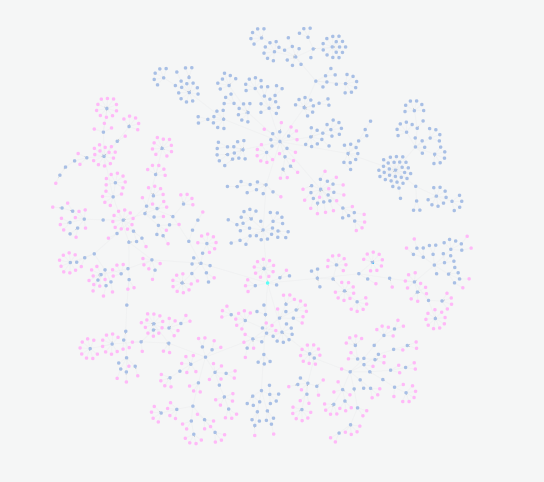

# Embeddings

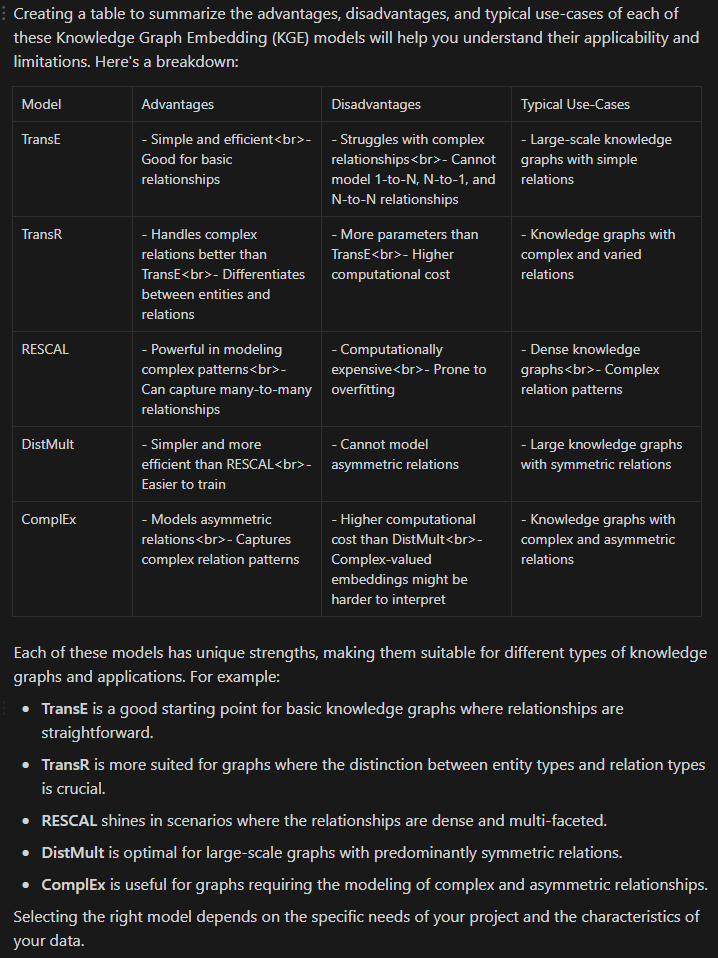

In [ ]:
from typing import Iterator
from llama_index.embeddings import OpenAIEmbedding
from llama_index import ServiceContext, set_global_service_context

embed_model = OpenAIEmbedding(embed_batch_size=10)

service_context = ServiceContext.from_defaults(embed_model=embed_model)

# optionally set a global service context
set_global_service_context(service_context)

from llama_index.embeddings import OpenAIEmbedding

embed_model = OpenAIEmbedding(model="text-embedding-3-large", dimensions=512)

In [ ]:
"""
LoadEmbedding: call OpenAI embedding API to generate embeddings for each property of node in Neo4j

Querying Neo4j Nodes: The function performs a query on the Neo4j database to retrieve nodes with a specific label (provided as the label parameter) and a property of those nodes (provided as the property parameter). The query also includes the parent section title of each node.

Generating Embeddings: For each retrieved node, it generates an embedding for the concatenated text (section title and property value) using the OpenAI Embedding API (get_embedding function). The embedding model used is specified by EMBEDDING_MODEL.

Creating Embedding Nodes in Neo4j: The generated embeddings are then used to create new Embedding nodes in the Neo4j database. These Embedding nodes are linked to the original nodes with a HAS_EMBEDDING relationship. The key property of the Embedding node differentiates different embeddings (based on the property parameter).

Counting Processed Nodes: The function keeps a count of how many nodes it has processed and prints this count at the end.
"""

def LoadEmbedding(label, property):
    driver = GraphDatabase.driver(NEO4J_URL, auth=(NEO4J_USER, NEO4J_PASSWORD), database=NEO4J_DATABASE)

    with driver.session() as session:
        # get chunks in document, together with their section titles
        result = session.run(f"MATCH (ch:{label}) -[:HAS_PARENT]-> (s:Section) RETURN id(ch) AS id, s.title + ' >> ' + ch.{property} AS text")
        # call OpenAI embedding API to generate embeddings for each property of node
        # for each node, update the embedding property
        count = 0
        for record in result:
            id = record["id"]
            text = record["text"]

            # TO DO: add text length threshold to skip short text
            # ####

            # For better performance, text can be batched
            embedding = embed_model.get_text_embedding(text)

            # key property of Embedding node differentiates different embeddings
            cypher = "CREATE (e:Embedding) SET e.key=$key, e.value=$embedding"
            cypher = cypher + " WITH e MATCH (n) WHERE id(n) = $id CREATE (n) -[:HAS_EMBEDDING]-> (e)"
            session.run(cypher,key=property, embedding=embedding, id=id )
            count = count + 1

        session.close()

        print("Processed " + str(count) + " " + label + " nodes for property @" + property + ".")
        return count

In [ ]:
from neo4j import GraphDatabase, exceptions

LoadEmbedding("Chunk", "sentences")

LoadEmbedding("Table", "name")

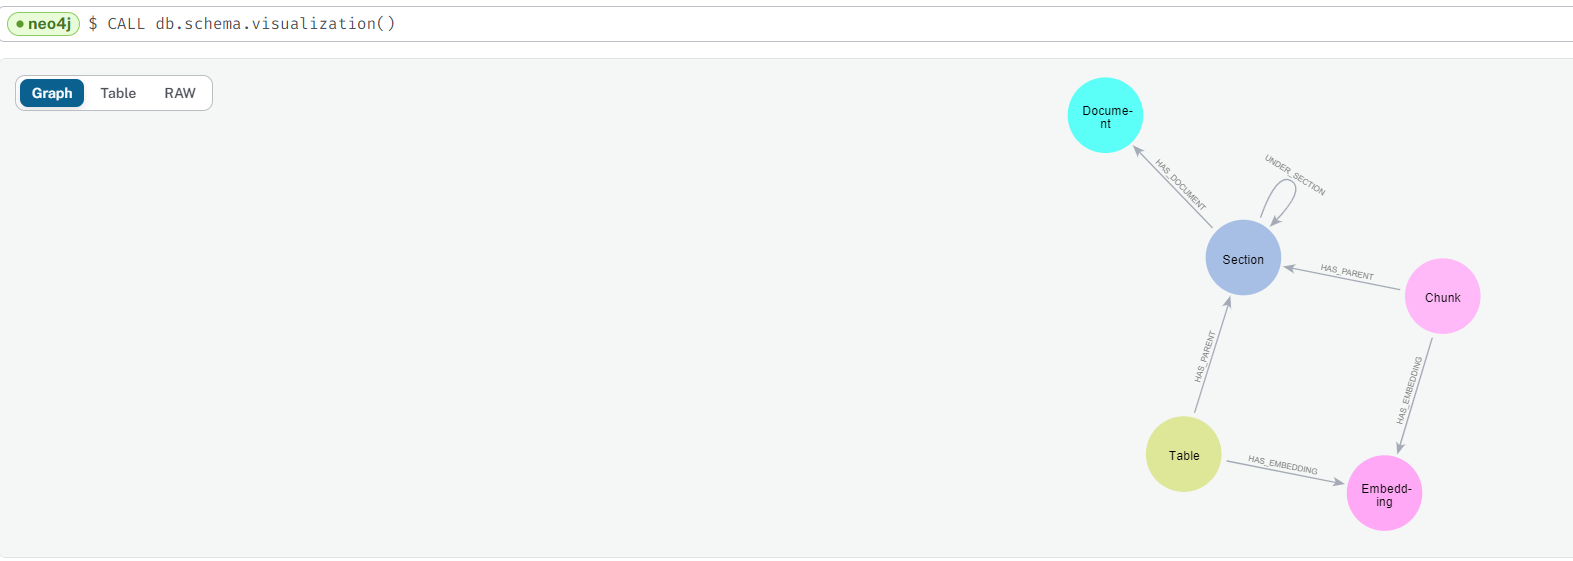

# II/ Domain Concept Extraction in order to create a Graphs

Extracting structured information from unstructured data like text has been around for some time and is nothing new. However, LLMs brought a significant shift to the field of information extraction. If before you needed a team of machine learning experts to curate datasets and train custom models, you only need access to an LLM nowadays. The barrier to entry has dropped significantly, making what was just a couple of years ago reserved for domain experts more accessible to even non-technical people.

The image depicts the transformation of unstructured text into structured information. This process, labeled as the information extraction pipeline, results in a graph representation of information. The nodes represent key entities, while the connecting lines denote the relationships between these entities. Knowledge graphs are useful for multi-hop question-answering, real-time analytics, or when you want to combine structured and unstructured data in a single database.

While extracting structured information from text has been made more accessible due to LLMs, it is by no means a solved problem. In this blog post, we will use OpenAI functions in combination with LangChain to construct a knowledge graph from a sample Wikipedia page. Along the way, we will discuss best practices as well as some limitations of current LLMs.


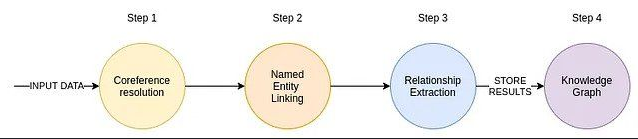

### Step 1: Coreference Resolution
Coreference resolution is the task of finding all expressions that refer to the same entity in a text. It's about understanding when two or more words refer to the same thing. For example, in the sentence "Alice drove her car, and she parked it in the garage," "Alice," "her," and "she" all refer to the same person, and "car" and "it" refer to the same object. This step is crucial for ensuring that later analysis is accurate because it consolidates different references to the same entity.
**Challenges:**
- **Ambiguity:** It can be challenging to resolve pronouns or other referring expressions when the referent is not clear. Ambiguity can arise due to complex sentence structures, multiple entities of the same type, or lack of context.
- **Long-distance coreferences:** When referring expressions and their referents are far apart in the text, LLMs might struggle to make the connection.
- **Common knowledge and assumptions:** Sometimes coreference resolution requires common sense or external knowledge, which may not be explicitly stated in the text.

### Step 2: Named Entity Linking (NEL)
Named Entity Linking (NEL) involves identifying and classifying key elements in text into predefined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc. After entities are identified, NEL goes a step further to link these entities to a unique identifier (like a database entry), often in a knowledge base. This allows the system to understand that different names or mentions can refer to the same real-world entity, even if they are spelled differently.
**Challenges:**
- **Entity Disambiguation:** Multiple entities can have the same name (e.g., "Jordan" could refer to a country or a person's name). Disambiguating these entities requires understanding context, which can be difficult.
- **Variations in Naming:** An entity might be referred to by different names, aliases, or titles, which can complicate the linking process.
- **Domain-Specific Entities:** LLMs may struggle with entities that are highly domain-specific without additional training data or context.

### Step 3: Relationship Extraction
Relationship Extraction is the task of detecting and categorizing semantic relationships between entities within a text. For example, in the sentence "Alice works for Acme Corporation," there is a relationship of "employment" between "Alice" and "Acme Corporation." This step is vital for building a knowledge graph because it starts to put together the entities in a meaningful way that represents real-world relationships.
**Challenges:**
- **Entity Disambiguation:** Multiple entities can have the same name (e.g., "Jordan" could refer to a country or a person's name). Disambiguating these entities requires understanding context, which can be difficult.
- **Variations in Naming:** An entity might be referred to by different names, aliases, or titles, which can complicate the linking process.
- **Domain-Specific Entities:** LLMs may struggle with entities that are highly domain-specific without additional training data or context.

### Step 4: Knowledge Graph
The final step is the storage of the results from the previous processes in a structured form known as a knowledge graph. A knowledge graph is a database that uses a graph-structured data model. It not only stores the entities and relationships extracted from the data but also enables the use of this structured information for various applications such as search engines, recommendation systems, and question-answering systems. It stores data in nodes (entities), edges (relationships), and properties (attributes and values of entities and relationships), allowing complex queries and analytics.
- **Data Inconsistency:** Combining information from multiple sources can lead to inconsistencies in the knowledge graph.
- **Maintaining Up-to-Date Information:** Knowledge graphs must be updated continuously to reflect the most current information, which can be resource-intensive.
- **Scalability:** As more entities and relationships are added, the knowledge graph becomes more complex, which can result in performance issues and increased difficulty in maintaining the graph.


Large Language Models (LLMs) like GPT-4 are highly capable when it comes to text understanding and generation, but they do face challenges at each step of the knowledge graph creation process.
In general, while LLMs are sophisticated in processing and generating language, the tasks involved in creating and maintaining a knowledge graph require not only understanding text but also structuring and inferring information in ways that are consistent and meaningful over large datasets and across various domains. These are non-trivial challenges that often require specialized architectures, datasets, and additional logic beyond the core capabilities of an LLM.

Zhu et al 2023 https://arxiv.org/pdf/2305.13168.pdf evaluates prominent LLMs such as ChatGPT and GPT-4 on various KG construction tasks like entity extraction, relation extraction, event extraction, and entity linking.

The performance of LLMs on KG construction tasks does not yet surpass specialized fine-tuned models developed specifically for these tasks. This is likely because KG construction involves multiple complex subtasks like named entity recognition and relation extraction :

Relation Extraction (RE)
Event Detection (ED)
Link Prediction (LP)
Question Answering (QA)
However, LLMs show promising capability improvements in one-shot and zero-shot settings over previous benchmarks. For example, GPT-4 demonstrates enhanced performance over ChatGPT in extracting relations from complex sentences.

There are several factors that currently limit the capabilities of LLMs for KG construction tasks, including dataset noise, semantic ambiguity, lack of type specifications, and prompt engineering.

The study introduces the concept of “Virtual Knowledge Extraction” to discern if LLM performance stems from memorized knowledge or true generalization ability. Initial findings indicate models like GPT-4 can rapidly acquire new extraction capabilities when provided sample instructions.

There are significant opportunities to enhance LLM capabilities for KG construction by optimizing prompt design, drawing on instructive examples for one-shot learning, accounting for dataset limitations, and leveraging human feedback.

While LLMs show promise for KG construction their capabilities do not yet exceed specialized systems. However, their ability to generalize provides optimism for future advancement in assisted and semi-automated KG construction pipelines.

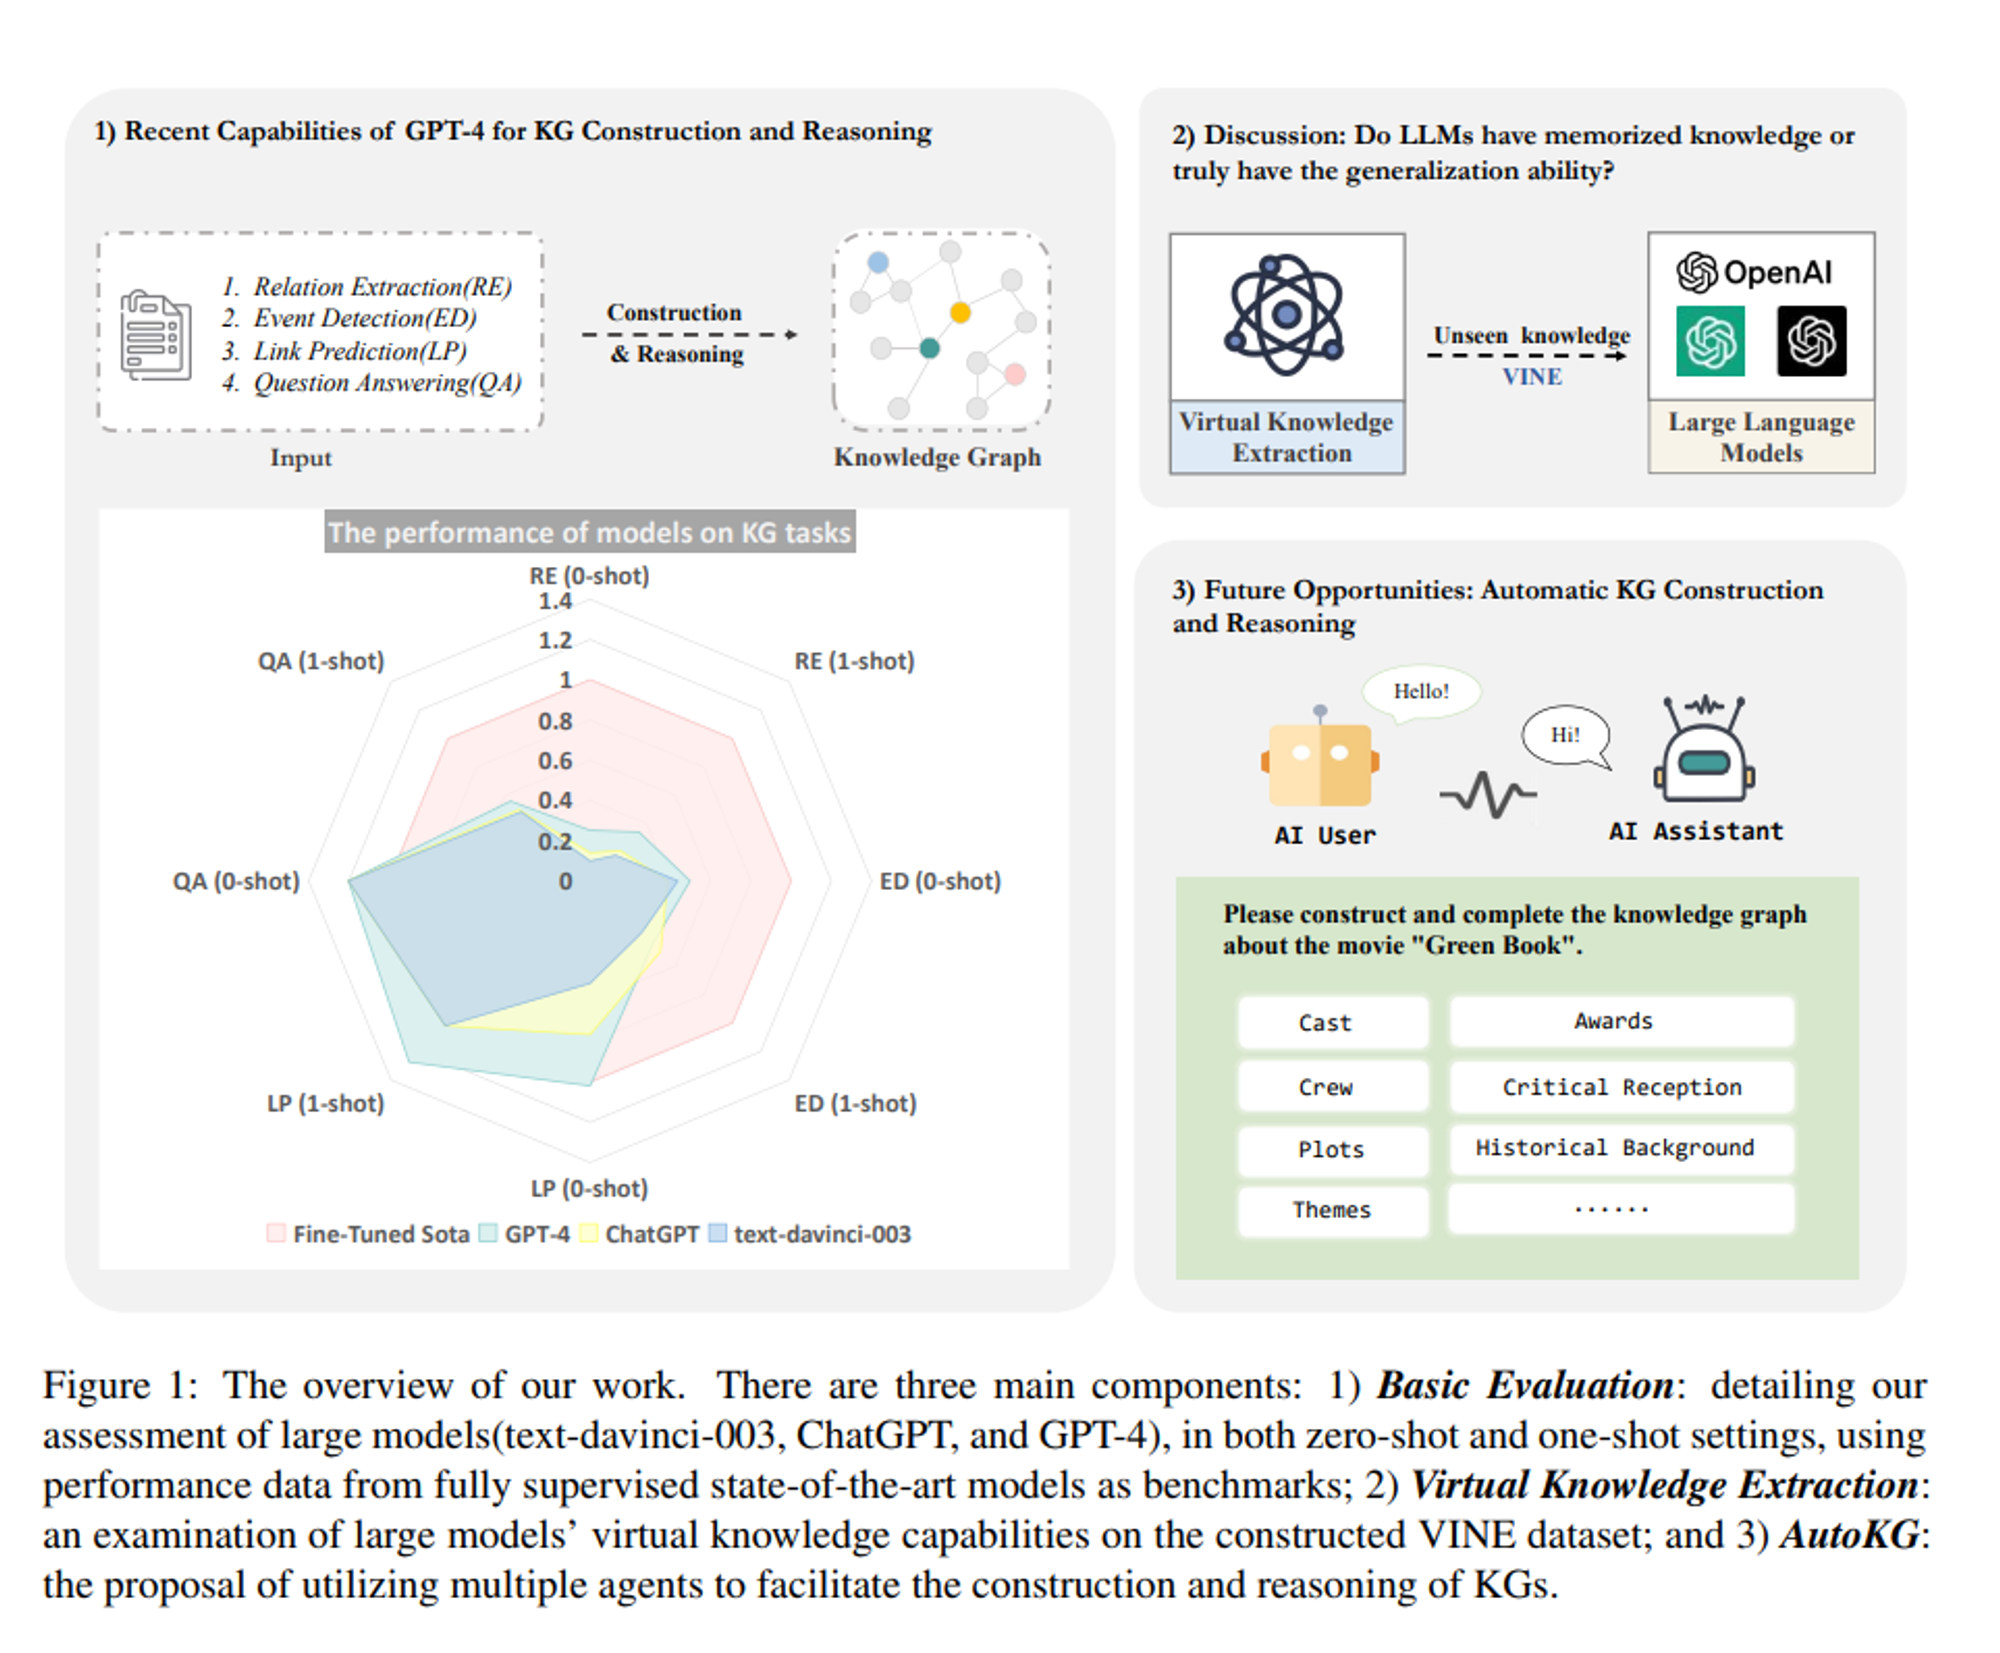

The capabilities of large language models (LLMs) for knowledge graph (KG) building based on the provided research:

| Capability                | Description                                                                  |
|---------------------------|------------------------------------------------------------------------------|
| Entity & Relation Extraction | - Improvements in zero-shot and one-shot extraction.                        |
|                            | - GPT-4 superior.                                                 |
|                            | - Still lag behind fully supervised models.                                  |
| Event Extraction           | - GPT-4 superior in generalizing contextual information.                     |
|                            | - Performance drops with sentence complexity.                                |
| Link Prediction            | - GPT-4 exceeds text-davinci-003 and ChatGPT.                                |
|                            | - Hits state-of-the-art level on FB15k-237 dataset.                           |
|                            | - Significant gains with one-shot learning.                                   |
| Question Answering         | - Match or exceed accuracy of supervised models.                              |
|                            | - GPT-4 substantially outperforms others on complex QA.                       |
|                            | - Accuracy drops with multiple possible answers.                             |
| Generalization Ability     | - Rapidly acquires capability for unseen extraction.                          |
|                            | - Effective learning from minimal instructions.                              |
|                            | - VINE results show strong generalization.                                    |
| Overall Assessment         | - GPT-4 demonstrates broad capabilities.                                      |
|                            | - Reasoning skills stronger than construction.                                 |
|                            | - Specialized domains remain challenging.                                     |
|                            | - Enhanced by multi-agent prompting.                                          |
|                            | - Reliant on manually crafted prompts.                                        |


Given the detailed explanation and the steps outlined for leveraging KeyBERT, HDBSCAN, and Zephyr-7B-Beta to build a knowledge graph, along with the specific workflow for clustering and labeling, I'll update the table to include these complementary techniques and clarify their roles in the knowledge graph construction process:

| Step                   | Usefulness of LLMs                                                                                                             | Complementary Techniques                                                  |
|------------------------|--------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------|
| 1. Data Collection     | - Identify and classify relevant documents<br>- Summarize content to help sampling<br>- Generate synthetic examples            |                                                                          |
| 2. Text Extraction     | - Post-process extraction output (propositions)                                                                        | OCR for digitizing scanned documents (example : llmsherpa https://github.com/nlmatics/llmsherpa)                                    |
| 3. Entity Extraction   | - Entity extraction                      | KeyBERT for initial keyword extraction                                   |
| 4. Relation Extraction | - Infer relationships between entities<br>- Classify relation types<br>- Attach relations to schemas                           |                                                                          |
| 5. Entity Normalization| - Cluster aliases<br>- Disambiguate terms<br>- Generate canonical names                                                        | Rule-based normalization (e.g., removing titles)                         |
| 6. Entity Clustering   | - Embed terms and phrases<br>- Summarize and label clusters<br>- Tune cluster granularity                                      | UMAP for dimensionality reduction, HDBSCAN for density-based clustering  |
| 7. Cluster Labeling    | - Produce descriptions<br>- Generate cluster titles<br>- Link cluster topics <br> - Zephyr-7B-Beta LLM for labeling and summarizing clusters                                                      |                 |
| 8. Entity Linking      | - Predict relationships<br>- Match to knowledge bases<br>- Transfer links from similar                                         |                                                                          |
| 9. Build KG            | - Construct node representations<br>- Predict adjacent entities<br>- Recommend model adjustments                               | Neo4j for constructing the property graph database                                |
| 10. Graph Analysis     | - Rank nodes by relevance<br>- Summarize subgraphs<br>- Query the graph  -LLM to do graph task (example : graphgpt)                                                      | PageRank, Eigenvector, Degree, Betweenness Centrality for graph analysis |

The complementary techniques such as KeyBERT, UMAP, HDBSCAN, and the use of Zephyr-7B-Beta for both keyword refinement and cluster labeling, play crucial roles alongside the capabilities of LLMs. These methods are instrumental in extracting, clustering, and labeling entities before structuring them into a knowledge graph using Neo4j. This multifaceted approach leverages both the advanced processing capabilities of LLMs and the specialized functionalities of other techniques to build a comprehensive and interconnected knowledge graph.

An example : https://github.com/SolanaO/Blogs_Content/blob/master/keyllm_neo4j/KeyBERT_LLM_Neo4j.ipynb

Information Extraction Pipeline

- Outlines the multi-step pipeline for extracting information from the documents, including document chunking, named entity recognition, relation extraction, and entity resolution

Step 1) The pipeline involves multiple steps to accurately extract information from the archival documents and structure it as a knowledge graph.

Step 2) Document chunking: Split up long documents into smaller diary entries using date extraction to identify entry boundaries. This maintains context needed for later steps.

Step 3) Named Entity Recognition (NER): Identify named entities like people, organizations in the unstructured text and classify them into predefined categories.

Step 4) Relation Extraction: Detect semantic relationships between extracted entities, like "works at" or "talked to" relations.

Step 5) Entity Resolution: Connect together variant mentions that refer to the same real-world entity, resolving them into a single node.

Step 6) The resulting structured knowledge graph can then be analyzed to understand connections and funding patterns.

The key steps are chunking to break documents into coherent contexts, followed by metadata extraction via NER and RE, and finally resolving entities into canonical nodes in the graph. 

An example of workflow from https://graphaware.com/features/

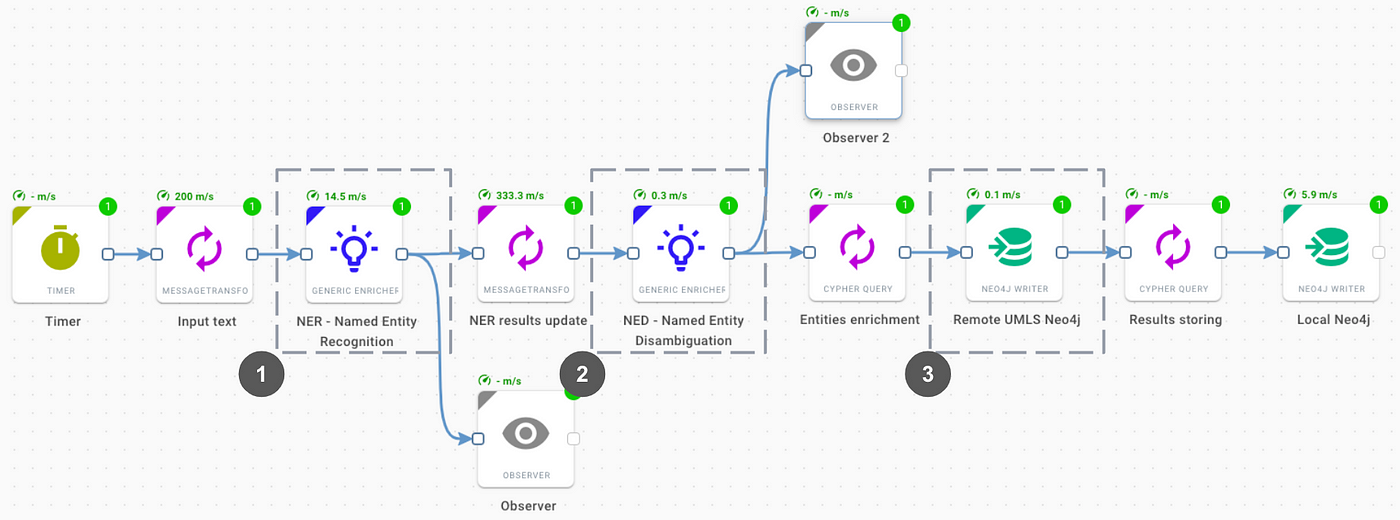

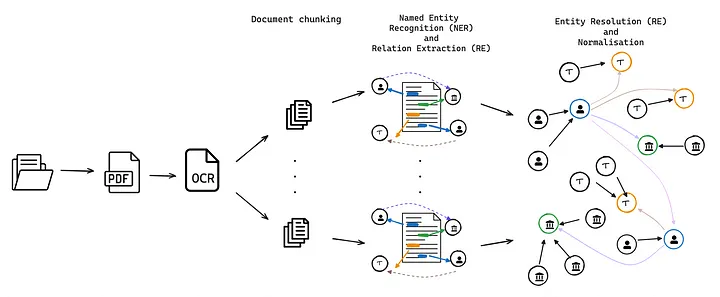

### 1) Extraction and chunking



The technique of decomposing passages into propositions https://arxiv.org/pdf/2312.06648.pdf can serve as a useful first step when building a knowledge graph from documents. Here's how:

From the paper, a proposition is described as:

Propositions are defined as atomic expressions within text, each encapsulating a distinct factoid and presented in a concise, self-contained natural language format.

Proposition extraction breaks down long, complex passages into shorter, simpler factual statements that each convey a distinct piece of information. This makes the content more accessible.
By extracting propositions, we segment the unstructured documents into atomic units of knowledge and facts.
Each proposition can then become a node in the knowledge graph. The nodes represent specific concepts, entities, events etc.
The relationships between propositions based on shared entities/arguments become the connections that form the overall graph structure.
So propositions provide the basic building blocks - the nodes and edges, to construct a network of facts and relations.
The resulting knowledge graph models the knowledge from the documents in a structured, interlinked manner.
It enables easier search, analysis and inference over the content through both graph algorithms as well as leveraging the inherent structure.
In summary, decomposing text into compact propositions facilitates systematic extraction of conceptual nodes and relationships from documents. This proposition-level network forms the foundation on which to construct a clean, structured knowledge graph that aptly represents the facts and relations locked within unstructured textual content.

The overall pipeline progress is:

Text -> Propositions -> Graph Nodes & Edges -> Knowledge Graph

# Effective Chunking of Unstructured Data for Knowledge Graph Construction Using LLMs

Transforming unstructured data into a structured knowledge graph involves several key steps. Here's a suggested approach leveraging Large Language Models (LLMs):

## 1. Preprocess and Clean Unstructured Data

- **Objective**: Clean the raw unstructured data to remove noise, making subsequent steps more effective.
- **Common Preprocessing Steps**:
  - Lowercasing text.
  - Removing punctuation/special characters.
  - Properly handling numbers and dates.

## 2. Define Information Extraction Schema

- **Objective**: Outline the entities, attributes, and relationships to extract based on your end-use case.
- **Example**: For a citations dataset, you might want to extract paper title, authors, venues, citations, etc.

## 3. Implement Recursive Text Chunking

- **Strategy**: Adopt a recursive chunking strategy, starting with semantic breaks like paragraphs. For larger chunks, recursively chunk further using entity characteristics to achieve coherence and self-containment.

## 4. Perform Entity/Relation Extraction

- **Using LLMs**: Leverage the preprocessed chunks and your defined schema to query the LLM to extract structured entities and relations, ensuring prompts conform to the schema.

## 5. Ground Extracted Concepts

- **Objective**: Align extracted entities and relations to existing ontologies/knowledge bases where possible, connecting extracted information to standard concepts.

## 6. Construct Knowledge Graph

- **Assembly**: With the structured extraction output, assemble a knowledge graph with nodes representing entities and edges representing relations. Ensure connections to grounded concepts.

## 7. Refine Extraction Strategy

- **Optimization**: Based on the quality assessment of the graph, refine your chunking strategy, schema constraints, etc., to optimize information extraction.

The key to successfully transforming unstructured data into rich, interconnected knowledge is to synergize chunking, extraction prompts, and grounding effectively.

In [ ]:
from llmsherpa.readers import LayoutPDFReader

llmsherpa_api_url = "https://readers.llmsherpa.com/api/document/developer/parseDocument?renderFormat=all"

pdf_reader = LayoutPDFReader(llmsherpa_api_url)

In [ ]:
import asyncio
import json
import yaml
from typing import Any, Dict, List, Optional

from llama_index import Document, ServiceContext, VectorStoreIndex
from llama_index.embeddings import OpenAIEmbedding, BaseEmbedding
from llama_index.llama_pack.base import BaseLlamaPack
from llama_index.llms import OpenAI
from llama_index.node_parser.interface import TextSplitter
from llama_index.node_parser.text import SentenceSplitter
from llama_index.response.schema import RESPONSE_TYPE
from llama_index.retrievers import RecursiveRetriever
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.schema import IndexNode, TextNode
from llama_index.prompts import PromptTemplate
from llama_index.async_utils import run_jobs

# backwards compatibility
try:
    from llama_index.llms.llm import LLM
except ImportError:
    from llama_index.llms.base import LLM


PROPOSITIONS_PROMPT = PromptTemplate(
    """Decompose the "Content" into clear and simple propositions, ensuring they are interpretable out of
context.
1. Split compound sentence into simple sentences. Maintain the original phrasing from the input
whenever possible.
2. For any named entity that is accompanied by additional descriptive information, separate this
information into its own distinct proposition.
3. Decontextualize the proposition by adding necessary modifier to nouns or entire sentences
and replacing pronouns (e.g., "it", "he", "she", "they", "this", "that") with the full name of the
entities they refer to.
4. Present the results as a list of strings, formatted in JSON.

Input: Title: ¯Eostre. Section: Theories and interpretations, Connection to Easter Hares. Content:
The earliest evidence for the Easter Hare (Osterhase) was recorded in south-west Germany in
1678 by the professor of medicine Georg Franck von Franckenau, but it remained unknown in
other parts of Germany until the 18th century. Scholar Richard Sermon writes that "hares were
frequently seen in gardens in spring, and thus may have served as a convenient explanation for the
origin of the colored eggs hidden there for children. Alternatively, there is a European tradition
that hares laid eggs, since a hares scratch or form and a lapwings nest look very similar, and
both occur on grassland and are first seen in the spring. In the nineteenth century the influence
of Easter cards, toys, and books was to make the Easter Hare/Rabbit popular throughout Europe.
German immigrants then exported the custom to Britain and America where it evolved into the
Easter Bunny."
Output: [ "The earliest evidence for the Easter Hare was recorded in south-west Germany in
1678 by Georg Franck von Franckenau.", "Georg Franck von Franckenau was a professor of
medicine.", "The evidence for the Easter Hare remained unknown in other parts of Germany until
the 18th century.", "Richard Sermon was a scholar.", "Richard Sermon writes a hypothesis about
the possible explanation for the connection between hares and the tradition during Easter", "Hares
were frequently seen in gardens in spring.", "Hares may have served as a convenient explanation
for the origin of the colored eggs hidden in gardens for children.", "There is a European tradition
that hares laid eggs.", "A hares scratch or form and a lapwings nest look very similar.", "Both
hares and lapwings nests occur on grassland and are first seen in the spring.", "In the nineteenth
century the influence of Easter cards, toys, and books was to make the Easter Hare/Rabbit popular
throughout Europe.", "German immigrants exported the custom of the Easter Hare/Rabbit to
Britain and America.", "The custom of the Easter Hare/Rabbit evolved into the Easter Bunny in
Britain and America." ]

Input: {node_text}
Output:"""
)


class DenseXRetrievalPack(BaseLlamaPack):
    def __init__(
        self,
        documents: List[Document],
        proposition_llm: Optional[LLM] = None,
        query_llm: Optional[LLM] = None,
        embed_model: Optional[BaseEmbedding] = None,
        text_splitter: TextSplitter = SentenceSplitter(),
        similarity_top_k: int = 4,
    ) -> None:
        """Init params."""
        self._proposition_llm = proposition_llm or OpenAI(
            model="gpt-3.5-turbo",
            temperature=0.1,
            max_tokens=750,
        )

        embed_model = embed_model or OpenAIEmbedding(embed_batch_size=128)

        nodes = text_splitter.get_nodes_from_documents(documents)
        sub_nodes = self._gen_propositions(nodes)

        all_nodes = nodes + sub_nodes
        all_nodes_dict = {n.node_id: n for n in all_nodes}

        service_context = ServiceContext.from_defaults(
            llm=query_llm or OpenAI(),
            embed_model=embed_model,
            num_output=self._proposition_llm.metadata.num_output,
        )

        self.vector_index = VectorStoreIndex(
            all_nodes, service_context=service_context, show_progress=True
        )

        self.retriever = RecursiveRetriever(
            "vector",
            retriever_dict={
                "vector": self.vector_index.as_retriever(
                    similarity_top_k=similarity_top_k
                )
            },
            node_dict=all_nodes_dict,
        )

        self.query_engine = RetrieverQueryEngine.from_args(
            self.retriever, service_context=service_context
        )

    async def _aget_proposition(self, node: TextNode) -> List[TextNode]:
        """Get proposition."""
        inital_output = await self._proposition_llm.apredict(
            PROPOSITIONS_PROMPT, node_text=node.text
        )
        outputs = inital_output.split("\n")

        all_propositions = []

        for output in outputs:
            if not output.strip():
                continue
            if not output.strip().endswith("]"):
                if not output.strip().endswith('"') and not output.strip().endswith(
                    ","
                ):
                    output = output + '"'
                output = output + " ]"
            if not output.strip().startswith("["):
                if not output.strip().startswith('"'):
                    output = '"' + output
                output = "[ " + output

            try:
                propositions = json.loads(output)
            except Exception:
                # fallback to yaml
                try:
                    propositions = yaml.safe_load(output)
                except Exception:
                    # fallback to next output
                    continue

            if not isinstance(propositions, list):
                continue

            all_propositions.extend(propositions)

        assert isinstance(all_propositions, list)
        nodes = [TextNode(text=prop) for prop in all_propositions if prop]

        sub_nodes = [IndexNode.from_text_node(n, node.node_id) for n in nodes]
        return sub_nodes

    def _gen_propositions(self, nodes: List[TextNode]) -> List[TextNode]:
        """Get propositions."""
        sub_nodes = asyncio.run(
            run_jobs(
                [self._aget_proposition(node) for node in nodes],
                show_progress=True,
                workers=8,
            )
        )

        # Flatten list
        return [node for sub_node in sub_nodes for node in sub_node]

    def get_modules(self) -> Dict[str, Any]:
        """Get modules."""
        return {
            "query_engine": self.query_engine,
            "retriever": self.retriever,
        }

    def run(self, query_str: str, **kwargs: Any) -> RESPONSE_TYPE:
        """Run the pipeline."""
        return self.query_engine.query(query_str)

In [ ]:
import os
import glob
from datetime import datetime
import time
import requests
from json import JSONDecodeError
import hashlib
import asyncio
import json
import yaml
from typing import Any, Dict, List, Optional

from llama_index import Document, ServiceContext, VectorStoreIndex
from llama_index.embeddings import OpenAIEmbedding, BaseEmbedding
from llama_index.llama_pack.base import BaseLlamaPack
from llama_index.llms import OpenAI
from llama_index.node_parser.interface import TextSplitter
from llama_index.node_parser.text import SentenceSplitter
from llama_index.response.schema import RESPONSE_TYPE
from llama_index.retrievers import RecursiveRetriever
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.schema import IndexNode, TextNode
from llama_index.prompts import PromptTemplate
from llama_index.async_utils import run_jobs

# backwards compatibility
try:
    from llama_index.llms.llm import LLM
except ImportError:
    from llama_index.llms.base import LLM

# Function to download PDF from a URL
def download_pdf(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)

pdf_url = "https://www.cio.gov/assets/resources/CISO_Handbook.pdf"  # Replace with your PDF URL
pdf_file_name = "downloaded_pdf.pdf"  # Replace with your desired PDF file name
pdf_file_location = "."  # Default Colab folder

# Download PDF
download_pdf(pdf_url, os.path.join(pdf_file_location, pdf_file_name))

pdf_files = glob.glob(pdf_file_location + '/*.pdf')
print(f'#PDF files found: {len(pdf_files)}!')

# Open a text file to write the propositions
with open("propositions_document.txt", "w", encoding="utf-8") as text_file:

    # Parse documents and generate propositions
    startTime = datetime.now()

    for pdf_file in pdf_files:
        try:
            doc = pdf_reader.read_pdf(pdf_file)

            # Extract file name from path
            idx = pdf_file.rfind('/')
            pdf_file_name = pdf_file[idx+1:]

            # Assuming doc.json is already a string representation of the document
            documents = [Document(text=json.dumps(doc.json))]
            proposition_llm = OpenAI(
                model="gpt-3.5-turbo",
                temperature=0.1,
                max_tokens=750,
            )
            text_splitter = SentenceSplitter()
            nodes = text_splitter.get_nodes_from_documents(documents)
            
            async def generate_propositions(nodes):
                propositions = []
                for node in nodes:
                    initial_output = await proposition_llm.apredict(PROPOSITIONS_PROMPT, node_text=node.text)
                    outputs = initial_output.split("\n")
                    for output in outputs:
                        if not output.strip():
                            continue
                        try:
                            propositions_json = json.loads(output)
                            if isinstance(propositions_json, list):
                                propositions.extend(propositions_json)
                        except Exception:
                            continue
                return propositions
            
            propositions = asyncio.run(generate_propositions(nodes))
            
            # Write the original text and propositions to the text file
            for node in nodes:
                text_file.write(f"Original Text: {node.text}\n")
                text_file.write("Propositions:\n")
                for prop in propositions:
                    text_file.write(f"{prop}\n")
                text_file.write("\n")  # Add a newline for separation between entries

        except JSONDecodeError as e:
            print(f"Error decoding JSON for file {pdf_file}: {e}")

    print(f'Total time: {datetime.now() - startTime}')

In [ ]:
from fpdf import FPDF

class PDF(FPDF):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.set_auto_page_break(auto=True, margin=15)
        # Replace PATH_TO_FONT_FILE with the actual path to the DejaVuSansCondensed.ttf font file
        self.add_font('DejaVu', '', 'PATH_TO_FONT_FILE', uni=True)
        self.set_font('DejaVu', '', 14)
    
    def header(self):
        self.set_font('DejaVu', '', 12)
        self.cell(0, 10, 'Propositions Document', 0, 1, 'C')

    def footer(self):
        self.set_y(-15)
        self.set_font('DejaVu', '', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

# Create instance of FPDF class with UTF-8 support
pdf = PDF()
pdf.add_page()

# Open the text file
with open("propositions_document.txt", "r", encoding="utf-8") as file:
    for line in file:
        pdf.cell(0, 10, line, ln=True)

# Save the pdf with name .pdf
pdf_file_path = os.path.join(pdf_file_location, "Propositions_Document_UTF8.pdf")
pdf.output(pdf_file_path)

print(f"PDF file has been created: {pdf_file_path}")

### 2) Named Entity Recognition and relation extraction (NER)

For a Chief Information Security Officer (CISO) aiming to apply knowledge graph technology, particularly in constructing a knowledge graph from diverse data sources like reports, logs, and documentation, the advice extracted from the previously discussed NER (Named Entity Recognition) and RE (Relation Extraction) challenges can be quite pertinent. This advice is especially relevant when integrating complex, unstructured data into a coherent, structured knowledge graph for cybersecurity insights. Here's how the advice translates to actionable steps for a CISO:

### 1. **Adherence to a Schema**

- **Define a Robust Schema**: Before processing data, define a comprehensive schema for your knowledge graph. This schema should include types of entities specific to cybersecurity (e.g., threats, assets, vulnerabilities, incidents) and the relationships among them (e.g., exploits, mitigations). This schema serves as a reference point to ensure that extracted entities and their relations align with your security domain's needs.

- **Schema-guided Entity Recognition**: Leverage the schema during the NER process to guide the model in recognizing entities that are relevant to cybersecurity. This can enhance the precision of entity extraction by focusing on those that fit your predefined categories.

### 2. **Co-reference Resolution**

- **Implement Context Bridging for Co-reference**: In the context of analyzing lengthy reports or logs, it's crucial to maintain continuity across segmented data chunks. Employ strategies to bridge context from one chunk to the next, ensuring that references to entities (like specific threats or incidents) are consistently understood across segments. This might involve including a summary of previously identified entities as part of the input for subsequent chunks.

- **Use Coreference Resolution Techniques**: Apply coreference resolution techniques to identify when different terms or pronouns refer to the same entity across your data sources. This is critical for building a cohesive knowledge graph where each node accurately represents a unique entity, and all relevant information about that entity is connected.

### 3. **Model Training and Customization**

- **Customize Models for Cybersecurity Context**: Train your NER and RE models on cybersecurity-specific datasets or fine-tune pre-trained models with domain-specific data. This helps the model to better understand the nuances of cybersecurity language and improve its ability to extract relevant entities and relationships.

- **Iterative Training with Feedback Loops**: Establish a process for regularly updating the model based on feedback from real-world usage. As new types of cybersecurity threats emerge, your model should adapt to recognize and incorporate these into the knowledge graph.

## What is OntoGPT?

1. **Knowledge Bases and Ontologies**: KBs and ontologies are structures that encode domain knowledge. It mentions general-purpose KBs like Wikidata that provide broad contextual knowledge useful for various tasks, and domain-specific KBs like the Gene Ontology, which are tailored to more specialized areas such as life sciences.
2. **Use of Knowledge Bases**: These KBs are used for tasks such as integrating gene product data and interpreting high-throughput experimental data. They involve curation, a process often led by human experts.
3. **Communication of Knowledge**: Historically, knowledge has been communicated textually in journals and articles, which has been challenging for machines to interpret.
4. **NLP and LLMs**: The text then moves on to discuss Natural Language Processing (NLP) and Large Language Models (LLMs) like GPT-3 and GPT-4. These models have shown great potential in understanding and generating natural language but have limitations, such as being prone to hallucinations (generating incorrect statements) and a lack of reliability that hasn’t been fully demonstrated yet.
5. **Assisting Manual Curation with LLMs**: The text suggests that LLMs could offer promise in assisting manual knowledge curation and validation while validating facts before their insertion into the KBs. It discusses the use of techniques such as Named Entity Recognition (NER) and Relation Extraction (RE) in this context.
6. **Task-Specific LLMs**: There is a mention of task-specific training data for LLMs and how the latest generation of models like GPT-3 and GPT-4 can generalize and perform zero-shot or few-shot learning on tasks without extensive task-specific data.
7. **Challenges with KB Schemas**: It is mentioned that most KBs are built upon detailed knowledge schemas that can be hard to populate, and customizing these schemas requires considerable engineering effort.
8. **Structured Prompt Interrogation and Recursive Extraction of Semantics (SPIRES)**: Finally, the text introduces an automated approach called SPIRES for populating KBs using publicly available databases and ontologies, bypassing the need for training examples. This method leverages LLMs for its advantages while addressing some of their reliability issues.

OntoGPT is an open source Python package for extracting structured information from text using large language models (LLMs) like GPT-3.5 and GPT-4. It utilizes instruction prompts and ontology-based grounding to output knowledge graphs, ontologies, and other structured data ([1][3][4][6]).

Key features:

- Implements two main knowledge extraction strategies:
    - SPIRES: Structured Prompt Interrogation and Recursive Extraction of Semantics ([1][3][6][9][12])
    - HALO: Hypothesis Assembly from Language and Ontologies ([6][9])
- Can extract nested semantic structures from text guided by a schema ([3][6][7][9][12])
- Grounds extractions to existing databases and ontologies ([3][5][7][12])
- Output can be used for tasks like named entity recognition, relation extraction, and knowledge base construction ([4])
- Compatible with GPT-3.5, GPT-4, and other LLMs ([1][4][6])

## Applications

OntoGPT has been used for:

- Extracting food recipes, cellular signaling pathways, disease treatments, drug mechanisms ([12])
- Population of knowledge bases ([12])
- General natural language tasks like summarization ([4])
- Clinical note generation ([10])

## Availability

OntoGPT is available on GitHub and PyPI. The code is open source and contributions are welcome ([1][3][6]). There is also a basic web interface included ([6][9]).

## Limitations

As noted in the search results, limitations of OntoGPT include:

- Non-deterministic output due to reliance on LLMs ([9])
- Difficulty handling deeply nested relationships ([7])
- Need for manual review and validation of extractions ([5][12])

Let me know if you have any other questions!

Sources
[1] GitHub - monarch-initiative/ontogpt: LLM-based ontological extraction tools, including SPIRES https://github.com/monarch-initiative/ontogpt
[2] Fan Li on LinkedIn: Explore OntoGPT for Schema-based Knowledge Extraction https://www.linkedin.com/posts/fanli_explore-ontogpt-for-schema-based-knowledge-activity-7071814273873661953-moRq
[3] Introducing OntoGPT: A toolkit for working with ontologies, knowledge bases, and GPT https://community.openai.com/t/introducing-ontogpt-a-toolkit-for-working-with-ontologies-knowledge-bases-and-gpt/251591
[4] Introduction https://monarch-initiative.github.io/ontogpt/
[5] [PDF] structured prompt interrogation and recursive extraction of semantics ... https://arxiv.org/pdf/2304.02711.pdf
[6] ontogpt https://pypi.org/project/ontogpt/0.3.2/
[7] Explore OntoGPT for Schema-based Knowledge Extraction https://apex974.com/articles/ontogpt-for-schema-based-knowledge-extraction
[8] Setup https://monarch-initiative.github.io/ontogpt/setup/
[9] ontogpt https://pypi.org/project/ontogpt/0.2.6/
[10] Releases · monarch-initiative/ontogpt https://github.com/monarch-initiative/ontogpt/releases
[11] Operation https://monarch-initiative.github.io/ontogpt/operation/
[12] Structured prompt interrogation and recursive extraction of semantics (SPIRES): A method for populating knowledge bases using zero-shot learning https://arxiv.org/abs/2304.02711
[13] ontogpt https://pypi.org/project/ontogpt/0.2.5/
[14] OntoGPT a natural language interface for SNOMED CT via a FHIR terminology server - Lawley & Ngo https://www.youtube.com/watch?v=5GykBNCeZy0
[15] GitHub - vemonet/ontogpt-api: ⛏️ An API to extract informations from text using OntoGPT https://github.com/vemonet/ontogpt-api

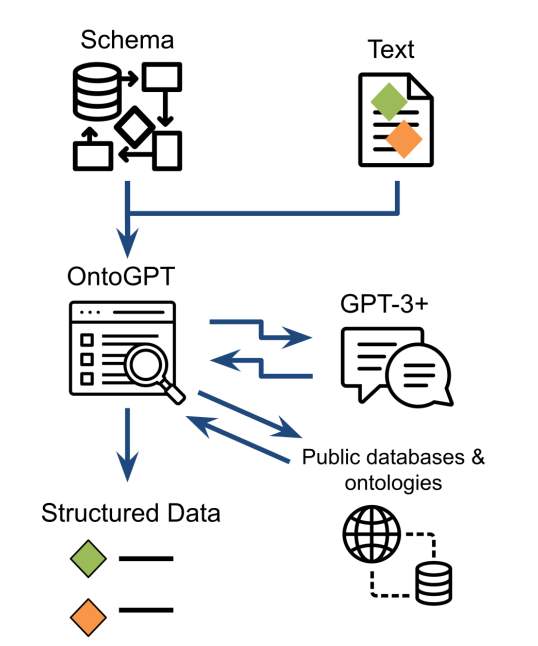

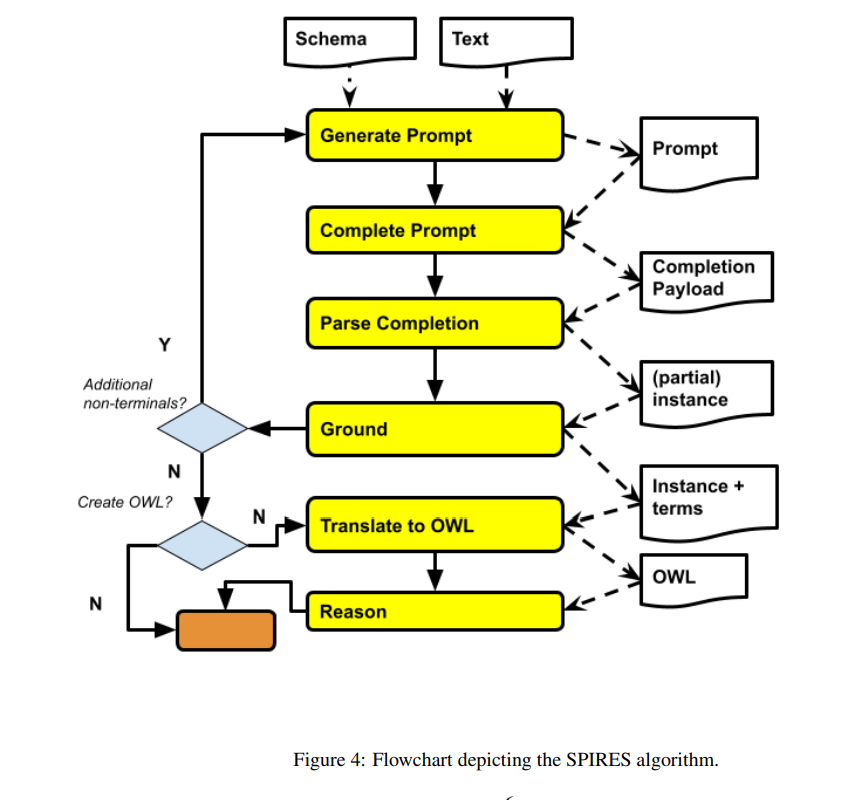

In [3]:
import logging
import sys
from llama_index.llms import OpenAI
from llama_index import ServiceContext
from llama_index import (
    KnowledgeGraphIndex,
    LLMPredictor,
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.storage.storage_context import StorageContext
from llama_index.graph_stores import Neo4jGraphStore
from IPython.display import Markdown, display

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# define LLM
llm = OpenAI(temperature=0.2, model="gpt-3.5-turbo-16k-0613") #gpt-4-0613 (or) #gpt-4-1106-preview
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1000)

In [4]:
documents = SimpleDirectoryReader(
    r"KG"
).load_data()

In [5]:
# Actual credentials for the Neo4j instance
NEO4J_URL = "neo4j+s://e06cd449.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "odDj37W_tSphbXefQ4HlBKsltwidiQDkwF6wlxYwzwY"
NEO4J_DATABASE = "neo4j"

# Initialize the Neo4jGraphStore with the actual credentials
graph_store = Neo4jGraphStore(
    username=NEO4J_USER,
    password=NEO4J_PASSWORD,
    url=NEO4J_URL,
    database=NEO4J_DATABASE,
)

# Create a StorageContext using the graph_store
storage_context = StorageContext.from_defaults(graph_store=graph_store)


In [6]:
from llama_index import Prompt

doc = {
    'allowed_nodes': [
        'Threat', 'Vulnerability', 'Asset', 'Incident', 'Policy', 
        'Control', 'Risk', 'Mitigation', 'AttackPattern', 'Malware', 
        'Phishing', 'Ransomware', 'DataBreach', 'Compliance', 'Regulation', 
        'SecurityTool', 'Patch', 'Update', 'User', 'Identity', 'Access', 
        'Encryption', 'Network', 'Endpoint', 'CloudService', 'Application'
    ],
    'allowed_rels': [
        'exploits', 'mitigates', 'affects', 'violates', 'compliesWith', 
        'detectedBy', 'uses', 'targets', 'originatesFrom', 'impacts', 
        'managedBy', 'securedBy', 'compromises', 'prevents', 'respondsTo', 
        'associatedWith', 'executes', 'deliveredThrough', 'accessedBy'
    ]
}

allowed_nodes = doc.get('allowed_nodes', [])
allowed_rels = doc.get('allowed_rels', [])

template = (f"""
    You are a sophisticated algorithm designed to extract cybersecurity-related information for constructing a knowledge graph tailored to a Chief Information Security Officer (CISO).
    - **Nodes** represent cybersecurity entities and concepts, crucial for understanding the security landscape.
    - The goal is to create a comprehensive and clear knowledge graph, serving as a valuable tool for CISOs to gain insights into cybersecurity threats, vulnerabilities, and controls.
    ## 2. Labeling Nodes
    - **Consistency**: Use clear and specific labels for node types, reflecting the cybersecurity domain.
      - For example, when identifying a software weakness, label it as **"Vulnerability"** rather than a more generic term like "issue".
    - **Node IDs**: Use descriptive, human-readable identifiers for node IDs, avoiding generic integers.
    - **Allowed Node Labels:** {", ".join(allowed_nodes)}
    - **Allowed Relationship Types:** {", ".join(allowed_rels)}
    ## 3. Handling Cybersecurity Data
    - Include relevant attributes for nodes, such as severity scores for vulnerabilities or the type of data compromised in a breach.
    - **Attribute Format**: Use a key-value format for node attributes, adhering to cybersecurity standards where applicable.
    - **Naming Convention**: Employ camelCase for attribute keys, ensuring consistency across the graph.
    ## 4. Coreference Resolution
    - **Entity Consistency**: Maintain consistent references to entities across the knowledge graph. For instance, if "SQL Injection" and "SQLi" refer to the same vulnerability, consistently use one identifier.
    - This consistency is vital for the usability and reliability of the knowledge graph, aiding CISOs in making informed decisions.
    ## 5. Compliance and Security Standards
    - Ensure the knowledge graph reflects compliance with relevant security standards and regulations, aiding in the strategic planning of cybersecurity measures.
    - **Strict Compliance**: Adherence to these guidelines is crucial for the integrity and usefulness of the knowledge graph.
    """)
qa_template = Prompt(template)

In [7]:
import logging

# Configure logging to display INFO level messages
logging.basicConfig(level=logging.INFO)

# Your existing code to create the index
index = KnowledgeGraphIndex.from_documents(
    documents,
    query_keyword_extract_template=qa_template,
    storage_context=storage_context,
    max_triplets_per_chunk=6,
    service_context=service_context,
    include_embeddings=True,
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST

In [8]:
index.storage_context.persist(persist_dir='KG')

"""
Only save metadata, knowledge graph is on the Neo4j server. 
"""

'\nOnly save metadata, knowledge graph is on the Neo4j server. \n'

# III/ Generating a Draft Graph Data Model with LLM Assistance from CSV

The key capabilities of large language models (LLMs) in designing graph databases from CSV data:

| Capability                           | Description                                                                                                                                                                                                                                             |
|--------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Structural Understanding of Tabular Data | LLMs can analyze CSV metadata like column names, data types, and value distributions to understand the data structure, allowing them to infer connections between columns that could represent entities or relationships in a graph.                    |
| Entity/Node Identification            | They identify columns representing unique objects or concepts (with identifiers, names, descriptions) that could be nodes/vertices in a graph database.                                                                                                  |
| Relationship Identification           | LLMs hypothesize relationships between entities based on names, meanings, and value patterns, using semantics and reasoning to find associations in the data.                                                                                           |
| Graph Model Generation                | They can generate a draft conceptual graph data model textually, defining nodes, relationships between them, and their properties for developer evaluation.                                                                                             |
| Explanation Capabilities              | LLMs provide explanations for their suggestions on nodes, relationships, and properties based on their data analysis, demonstrating reasoning behind the design choices.                                                                                |

How LLMs leverage their understanding of data structure and semantics to design property graph database models, providing a foundational step for developers in database development.

https://github.com/jbarrasa/goingmeta/tree/main/session25

https://github.com/jbarrasa/goingmeta/blob/main/session25/python/GM_25_LLMs_for_automated_KG_construction.ipynb

https://github.com/danb-neo4j/llm/blob/main/notebooks/llm-gen-KG-from-CSV.ipynb



Here's an extension to the previous table, including the additional capabilities of LLMs in suggesting constraints for a graph data model when analyzing CSV data:

| Capability                       | Description                                                                                                                                                                                                                   |
|----------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Unique ID Constraints            | LLMs identify columns with unique values or identifiers, suggesting a uniqueness constraint on nodes derived from these columns.                                                                                               |
| Relationship Cardinality         | They determine relationship cardinalities (one-to-one, one-to-many, many-to-many) based on column value patterns, suggesting appropriate cardinality constraints.                                                             |
| Data Type/Value Constraints      | Analyzing data types and value distributions, LLMs suggest constraints on expected data types or allowable values for node properties.                                                                                        |
| Optional vs. Mandatory Properties| For columns allowing nulls, LLMs might suggest mapping these to optional properties in the graph, contrasting with required properties by default.                                                                            |
| Referential Integrity Constraints| Identifying potential foreign key-style relationships, LLMs can recommend mapping these to relationships with enforced referential integrity.                                                                                  |

This extension highlights the nuanced ability of LLMs to propose meaningful constraints, further enhancing the precision and reliability of auto-generated graph data models by addressing uniqueness, cardinality, data integrity, and property optionality.